In this notebook, we aim to learn an approximation of the parity function over a manifold of data for which we prove that it is hard to learn from. These experiments verify theoretical findings.

In [ ]:
import torch
import math
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import random


loss_fn = nn.MSELoss()

pi = math.pi

def create_feedforward_network(n, L, widths):
    class FeedforwardNetwork(nn.Module):
        def __init__(self):
            super(FeedforwardNetwork, self).__init__()

            # Input layer
            layers = [nn.Linear(n, widths[0]), nn.ReLU()]

            # Hidden layers
            for i in range(1, L):
                layers += [nn.Linear(widths[i - 1], widths[i]), nn.ReLU()]

            # Output layer
            layers += [nn.Linear(widths[-1], 1)]

            # Define the sequential model
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x).flatten()

    return FeedforwardNetwork()



In [ ]:
def random_bitstring(batch_size, n):
    return torch.randint(2, size=(batch_size, n))

def increment_bitstring(bitstrings):
    bitstrings = torch.clone(bitstrings)
    increment = torch.ones((bitstrings.shape[0])).type(torch.int)
    for i in range(bitstrings.shape[-1]):
        bitstrings[:,-i-1] += increment
        increment[:] = 0
        increment[bitstrings[:,-i-1] == 2] = 1
    return bitstrings % 2

def gray_convert(bitstrings_tensor):
    # Convert bitstrings to binary reflected Gray code
    bitstrings_tensor[:,1:] = (bitstrings_tensor[:,1:] + bitstrings_tensor[:,:-1]) % 2

    return bitstrings_tensor.type(torch.float32)

def parity_appr(inputs, S):
    # Sum the input over the elements in S
    sum_S = torch.sum(inputs[:, S], dim=1)

    # Identify odd and even sums
    odd_sums = (sum_S % 2) >= 1

    # Calculate the output based on odd and even sums
    output = torch.where(
        odd_sums,
        2-(sum_S % 2) ,
        (sum_S % 2)
    )

    return output.type(torch.float32)

class f_parity_handler:
    def __init__(self, n=50):
        self.n = n
        self.S = random.sample(range(n//2), n//4)

    def generate_inputs_and_outputs(self, batch):
        # Get neighboring elements in Gray Code
        v_prev = random_bitstring(batch, n)
        v = increment_bitstring(v_prev)
        v_next = increment_bitstring(v)

        v_prev = gray_convert(v_prev)
        v = gray_convert(v)
        v_next = gray_convert(v_next)

        # Get interval along the manifold
        t_values = torch.rand((batch, 1)) * (pi/2)

        # Interpolate to get the value along manifold
        x = (
                (v_prev + v_next)* np.ones(t_values.shape) / 2 +
                ((v-v_next) / 2) * np.cos(t_values) +
                ((v-v_prev) / 2) * np.sin(t_values)
        )

        # Convert outputs to be in range [-1,+1] rather than [0,1] to be more balanced
        return x.type(torch.float32), 2*parity_appr(x, self.S)-1



In [ ]:

def test(model, test_x, test_y):
    with torch.no_grad():
        output = model(test_x)
        loss = loss_fn(output, test_y)
        errors = class_error(output, test_y)
        return loss.item(), errors.item()/len(test_y)

def class_error(y1,y2):
    return torch.sum(torch.sgn(y1) != torch.sgn(y2))

def train(model, optimizer, T, train_x, train_y, test_x, test_y, batch_size):
    def update_dict(epoch, loss, test_loss, train_error, test_error):
        out_dict['epoch'].append(epoch)
        out_dict['train_mse'].append(avg_loss)
        out_dict['test_mse'].append(test_loss)
        out_dict['train_error'].append(avg_train_error)
        out_dict['test_error'].append(test_error)
        return out_dict

    out_dict = {'epoch': [],
                'train_mse': [],
                'test_mse': [],
                'train_error': [],
                'test_error': []}

    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.MSELoss()
    class_error = nn.MSELoss()

    for epoch in range(T):
        total_loss = 0.
        total_errors = 0.

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            train_error = class_error(output, batch_y)/len(batch_y)

            total_loss += loss.item()
            total_errors += train_error.item()

        avg_loss = total_loss / len(train_loader)
        avg_train_error = total_errors / len(train_loader)

        test_loss, test_error = test(model, test_x, test_y)
        out_dict = update_dict(epoch, avg_loss, test_loss, avg_train_error, test_error)

        if (epoch % 20) == 0:
            print(f"Epoch {epoch}:")
            print(f"  Train MSE: {avg_loss}")
            print(f"  Test MSE: {test_loss}\n")
            print(f"  Train Error: {avg_train_error}")
            print(f"  Test Error: {test_error}\n")

        if ((epoch+1) % 200) == 0:
            for g in optimizer.param_groups:
                g['lr'] /= 2.


    return out_dict





def run(n = 10,  # Number of nodes
        n_train = 500,  # Number of training points
        n_test = 500,  # Number of test points
        T = 5000,  # Number of epochs
        width = 100,
        batch_size = 32,
        device = 'cuda',
        dataset_creator = f_parity_handler,
        dataset_name = 'High Order NN'
        ):

    loss_fn = nn.MSELoss()

    dataset_handler = dataset_creator(n=n)

    train_x, train_y = dataset_handler.generate_inputs_and_outputs(n_train)
    test_x,  test_y  = dataset_handler.generate_inputs_and_outputs(n_test)
    if device == 'cuda':
      train_x = train_x.to('cuda')
      train_y = train_y.to('cuda')
      test_x = test_x.to('cuda')
      test_y = test_y.to('cuda')

    # model = CyclicConvNet(n=n, num_conv_layers=3, num_fully_connected_layers=1, width = width).to(device)
    model = create_feedforward_network(n, L=1, widths = [width]*1).to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    out_dict = train(model, optimizer, T, train_x, train_y, test_x, test_y, batch_size)

    out_dict['n'] = n
    out_dict['function class'] = dataset_name
    return out_dict


def train_online(model, optimizer, T, dataset_handler, test_x, test_y, batch_size, device):
    def update_dict(epoch, loss, test_loss, train_error, test_error):
        out_dict['epoch'].append(epoch)
        out_dict['train_mse'].append(loss)
        out_dict['test_mse'].append(test_loss)
        out_dict['train_error'].append(train_error)
        out_dict['test_error'].append(test_error)
        return out_dict

    out_dict = {'epoch': [],
                'train_mse': [],
                'test_mse': [],
                'train_error': [],
                'test_error': []}

    loss_fn = nn.MSELoss()

    for epoch in range(T):

        batch_x, batch_y = dataset_handler.generate_inputs_and_outputs(batch_size)
        # if device == 'cuda':
        #     train_x = train_x.to('cuda')
        #     train_y = train_y.to('cuda')


        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        train_error = class_error(output, batch_y).item()/len(batch_y)

        optimizer.step()

        total_loss = loss.item()

        test_loss, test_error = test(model, test_x, test_y)
        out_dict = update_dict(epoch, total_loss, test_loss, train_error, test_error)

        if (epoch % 200) == 0:
            print(f"Epoch {epoch}:")
            print(f"  Train MSE: {total_loss}")
            print(f"  Test MSE: {test_loss}\n")
            print(f"  Train Error: {train_error}")
            print(f"  Test Error: {test_error}\n")

        if ((epoch+1) % 2000) == 0:
            for g in optimizer.param_groups:
                g['lr'] /= 2.


    return out_dict

def run_online(n = 10,  # Number of nodes
        n_train = 500,  # Number of training points
        n_test = 500,  # Number of test points
        T = 5000,  # Number of total steps
        width = 100,
        layers = 1,
        batch_size = 32,
        device = 'cuda',
        dataset_creator = f_parity_handler,
        dataset_name = 'Parity'
        ):

    loss_fn = nn.MSELoss()

    dataset_handler = dataset_creator(n=n)

    test_x,  test_y  = dataset_handler.generate_inputs_and_outputs(n_test)
    if device == 'cuda':
      test_x = test_x.to('cuda')
      test_y = test_y.to('cuda')

    # model = CyclicConvNet(n=n, num_conv_layers=3, num_fully_connected_layers=1, width = width).to(device)
    model = create_feedforward_network(n, L=layers, widths = [width]*layers).to(device)
    optimizer = Adam(model.parameters(), lr=0.001*np.exp(np.random.uniform(-2,1)))

    out_dict = train_online(model, optimizer, T, dataset_handler, test_x, test_y, batch_size, device)

    out_dict['n'] = n
    out_dict['function class'] = dataset_name
    return out_dict

In [ ]:
import pandas as pd
import numpy as np

def dict_to_pd(in_dict):
    in_dict['random_id'] = np.random.randint(999999)
    need_init = True
    for key in ['mse','error']:
        for choice in ['train', 'test']:
            out_dict = in_dict.copy()
            out_dict['metric'] = '0/1 Error' if key=='error' else 'MSE'
            out_dict['data'] = 'Train Set' if choice=='train' else 'Test Set'
            out_dict['error'] = out_dict[choice+'_'+key]
            df = pd.DataFrame.from_dict(out_dict)

            if need_init:
                df_out = df
                need_init = False
            else:
                df_out = pd.concat([df_out,df])
    return df_out

loss_fn = nn.MSELoss()
dfs = []
for _ in range(5):
    for n in [10,20,50]:
        out_dict = run_online(n = n,  # Number of nodes
            n_train = n*n,  # Number of training points
            n_test = 500,  # Number of test points
            T = 20000,  # Number of epochs
            width = 2*n,
            layers = 1,
            dataset_creator = f_parity_handler,
            dataset_name = 'Parity',
            device = 'cpu'
            )
        dfs.append(dict_to_pd(out_dict))

df_final = pd.concat(dfs)
print(df_final)


Streaming output truncated to the last 5000 lines.
  Train Error: 0.5
  Test Error: 0.524

Epoch 18000:
  Train MSE: 1.001323938369751
  Test MSE: 1.0010391473770142

  Train Error: 0.53125
  Test Error: 0.524

Epoch 18200:
  Train MSE: 1.0013117790222168
  Test MSE: 1.0010294914245605

  Train Error: 0.53125
  Test Error: 0.524

Epoch 18400:
  Train MSE: 0.9988867044448853
  Test MSE: 1.0010195970535278

  Train Error: 0.46875
  Test Error: 0.524

Epoch 18600:
  Train MSE: 0.998895525932312
  Test MSE: 1.0010100603103638

  Train Error: 0.46875
  Test Error: 0.524

Epoch 18800:
  Train MSE: 0.9977169632911682
  Test MSE: 1.0010013580322266

  Train Error: 0.4375
  Test Error: 0.524

Epoch 19000:
  Train MSE: 1.0036203861236572
  Test MSE: 1.000992774963379

  Train Error: 0.59375
  Test Error: 0.524

Epoch 19200:
  Train MSE: 1.0012551546096802
  Test MSE: 1.0009840726852417

  Train Error: 0.53125
  Test Error: 0.524

Epoch 19400:
  Train MSE: 1.0000858306884766
  Test MSE: 1.0009752

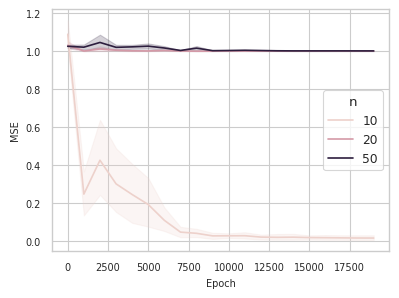

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})

df_plot = df_final[df_final['epoch'].isin(np.arange(100)*1000)]
df_plot = df_plot[df_plot['metric'].isin(['MSE'])]

ax = sns.lineplot(x="epoch", y="test_mse",
                hue="n",
                data=df_plot)

handles, labels = ax.get_legend_handles_labels()

ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='both', which='minor', labelsize=7)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')




fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.tight_layout()

# Save the figure as a PDF
fig.savefig("parity_training_curves.pdf")

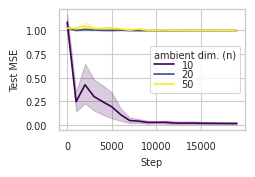

In [ ]:
sns.color_palette("colorblind")

plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})


ax = sns.lineplot(x="epoch", y="test_mse",
                hue="n", #style="function class",
                data=df_plot, palette = 'viridis')

handles, labels = ax.get_legend_handles_labels()

legend = ax.legend(handles = handles, labels = labels, fontsize=7,
                   labelspacing=-0.02, alignment = 'left',
                   title = 'ambient dim. (n)', title_fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='both', which='minor', labelsize=7)
ax.set_xlabel('Step')
ax.set_ylabel('Test MSE')



fig = plt.gcf()
fig.set_size_inches(2.5, 1.8)
plt.tight_layout()

# Save the figure as a PDF
fig.savefig("parity_training_curves.pdf")

Repeating experiments where the trained network now has 3 layers.

In [7]:
import pandas as pd
import numpy as np

def dict_to_pd(in_dict):
    in_dict['random_id'] = np.random.randint(999999)
    need_init = True
    for key in ['mse','error']:
        for choice in ['train', 'test']:
            out_dict = in_dict.copy()
            out_dict['metric'] = '0/1 Error' if key=='error' else 'MSE'
            out_dict['data'] = 'Train Set' if choice=='train' else 'Test Set'
            out_dict['error'] = out_dict[choice+'_'+key]
            df = pd.DataFrame.from_dict(out_dict)

            if need_init:
                df_out = df
                need_init = False
            else:
                df_out = pd.concat([df_out,df])
    return df_out

loss_fn = nn.MSELoss()
dfs = []
for _ in range(5):
    for n in [10,20,50]:
        out_dict = run_online(n = n,  # Number of nodes
            n_train = n*n,  # Number of training points
            n_test = 500,  # Number of test points
            T = 20000,  # Number of epochs
            width = 2*n,
            layers = 3,
            dataset_creator = f_parity_handler,
            dataset_name = 'Parity',
            device = 'cpu'
            )
        dfs.append(dict_to_pd(out_dict))

df_final = pd.concat(dfs)
print(df_final)


Streaming output truncated to the last 5000 lines.
  Train Error: 0.4375
  Test Error: 0.512

Epoch 18000:
  Train MSE: 1.0127884149551392
  Test MSE: 1.0039880275726318

  Train Error: 0.5625
  Test Error: 0.512

Epoch 18200:
  Train MSE: 0.9964914917945862
  Test MSE: 1.0038530826568604

  Train Error: 0.46875
  Test Error: 0.512

Epoch 18400:
  Train MSE: 1.0017286539077759
  Test MSE: 1.0037237405776978

  Train Error: 0.5
  Test Error: 0.512

Epoch 18600:
  Train MSE: 0.991494357585907
  Test MSE: 1.0035996437072754

  Train Error: 0.4375
  Test Error: 0.512

Epoch 18800:
  Train MSE: 1.0015727281570435
  Test MSE: 1.0034756660461426

  Train Error: 0.5
  Test Error: 0.512

Epoch 19000:
  Train MSE: 1.0014979839324951
  Test MSE: 1.0033549070358276

  Train Error: 0.5
  Test Error: 0.512

Epoch 19200:
  Train MSE: 0.987262487411499
  Test MSE: 1.0032390356063843

  Train Error: 0.40625
  Test Error: 0.512

Epoch 19400:
  Train MSE: 1.0013587474822998
  Test MSE: 1.0031276941299438

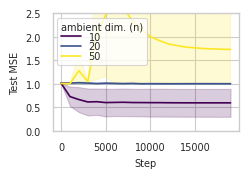

In [9]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})

sns.color_palette("colorblind")

plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})

# df_plot = df_final[df_final['epoch'].isin(np.arange(500)*5)]
# df_plot = df_final[df_final['function class'] == 'High Order NN']
df_plot = df_final[df_final['epoch'].isin(np.arange(100)*1000)]
df_plot = df_plot[df_plot['metric'].isin(['MSE'])]

ax = sns.lineplot(x="epoch", y="test_mse",
                hue="n", #style="function class",
                data=df_plot, palette = 'viridis')

handles, labels = ax.get_legend_handles_labels()

legend = ax.legend(handles = handles, labels = labels, fontsize=7,
                   labelspacing=-0.02, alignment = 'left',
                   title = 'ambient dim. (n)', title_fontsize = 7)
# ax.legend(handles=handles[1:3]+handles[4:], labels=labels[1:3]+labels[4:],ncol=2, fontsize=7, labelspacing=-0.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='both', which='minor', labelsize=7)
ax.set_xlabel('Step')
ax.set_ylabel('Test MSE')
ax.set_ylim([0,2.5])


fig = plt.gcf()
fig.set_size_inches(2.5, 1.8)
plt.tight_layout()

# Save the figure as a PDF
fig.savefig("parity_training_curves_3layers.pdf")